In [1]:
#!sudo /opt/conda/bin/conda install conda-build -y

In [2]:
#!sudo /opt/conda/bin/conda-develop -n QML-QPF PATH /workspaces/QML-QPF/mosaiQue

In [1]:

#import tensorflow as tf
#from tensorflow import keras
import mosaique as mq
from concurrent.futures import ProcessPoolExecutor, as_completed
import itertools
import numpy as np
import pennylane as qml
import os
import time
from matplotlib import pyplot as plt
from mosaique.models.operation import OperationLayer
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


def operation():
    dev = qml.device("default.qubit.tf", wires=4)
    @qml.qnode(dev, interface='tf')
    def cnot(inputs):
        inputs = inputs * np.pi
        qml.AngleEmbedding(inputs[:,...], wires=range(4), rotation='Y')

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(4)]
    return cnot

2024-11-25 16:28:33.684510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 16:28:34.413664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
def color_merge(dataset):
    return np.mean(dataset, axis=-1)
      


from tensorflow import keras
cifar_dataset = keras.datasets.cifar10
tr_layer = mq.ConvolutionLayer4x4("cifar_train")
te_layer = mq.ConvolutionLayer4x4("cifar_test")
(tr_images, tr_labels), (te_images, te_labels) = cifar_dataset.load_data()
tr_images = color_merge(tr_images)
te_images = color_merge(te_images)



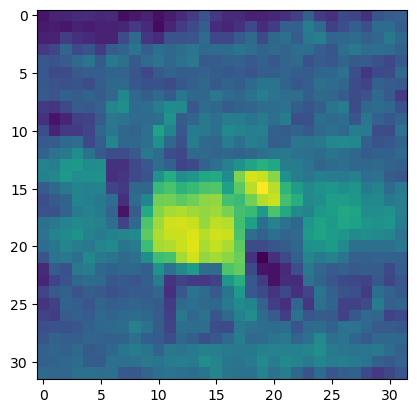

In [22]:
plt.imshow(tr_images[3])

In [ ]:


tr_layer.fit(tr_images)
te_layer.fit(te_images)
tr_images = tr_layer.transform(tr_images)
te_images = te_layer.transform(te_images)


In [ ]:
print((tr_images[:, 1::2, 1::2]).shape)

(tr_images[:, 1::2, 1::2]) = 255

print(tr_images.shape)

tr_images2 = tr_layer.transform(tr_images)

te_images2 = te_layer.transform(te_images)

print(tr_images2.shape)

plt.imshow(tr_images2[0,:,1].reshape((-1,14)))



In [ ]:
permutations = np.asarray(list(itertools.permutations(range(4))))

op = OperationLayer(operation())
#predict = op.pre_op.predict(tr_images2[:,:,permutations[-1]])
predict = op.pre_op.predict(tr_images2,batch_size=5)

#print(tr_images2[:,:,permutations[-1]].shape)
print(predict.shape)
#print(permutations[-1])


In [5]:
permutations = np.asarray(list(itertools.permutations(range(4))))

def pool(x, call, p, l):
    #sleep_duration = np.random.randint(1, 5) # Sleep between 1 and 4 seconds
    #time.sleep(sleep_duration)
    op = OperationLayer(call())
    predict = l.post_transform(op.pre_op.predict(x,batch_size=1000))
    l.save(predict, p)



In [ ]:
_min, _max = np.amin(predict), np.amax(predict)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

print(_min,_max)

# Plot all output channels for quantum cnot
for c in range(4):
    axes[c].imshow(predict[0,c,:].reshape((14,14)),vmin = _min, vmax = _max)